In [1]:
## Cells labeled "from github" were taken from: "https://github.com/EncinasBartos/QuasiObjectiveEddyVisualizationFromSparseDrifterData"
## if cell is labeled "from github (adapted)", the original cell was altered

import pandas as pd
import csv
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import math
from scipy.stats import norm
from scipy.stats import shapiro
from scipy import signal
from scipy.signal import butter
from scipy.signal import bode
import scipy.interpolate
from scipy.interpolate import RBFInterpolator
from scipy.interpolate.rbf import Rbf
import metpy
from metpy.interpolate import interpolate_to_grid
from tqdm.notebook import tqdm
from matplotlib.colors import LinearSegmentedColormap
import os
import os.path
from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
from scipy.spatial import ConvexHull, convex_hull_plot_2d
from scipy.interpolate import RectBivariateSpline as RBS
from skimage.feature import peak_local_max
from skimage import measure

# import math tools
from math import radians, sin, cos, asin, sqrt

from tqdm.notebook import tqdm
import time as TIME
import global_land_mask
from global_land_mask import globe
import random

In [2]:
##from github

## parula colormap

cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905],
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143],
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952,
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286],
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238,
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571],
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571,
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429],
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667,
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286],
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571,
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429],
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524,
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048,
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667],
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381,
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381],
 [0.0589714286, 0.6837571429, 0.7253857143],
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429],
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429,
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048],
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619,
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667],
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524,
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905],
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476,
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143],
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333],
 [0.7184095238, 0.7411333333, 0.3904761905],
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667,
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762],
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217],
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857,
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619],
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857,
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381],
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857],
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309],
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333,
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333],
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)

In [3]:
##returns minutes between utc and utc0 (time format: "YYYY-mm-ddT00:00:00Z")

def utc_to_minutes(utc, utc0):
    minutes = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").minute
    minutes0 = datetime.strptime(utc0, "%Y-%m-%dT%H:%M:%SZ").minute
    hours = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").hour
    hours0 = datetime.strptime(utc0, "%Y-%m-%dT%H:%M:%SZ").hour
    month0 = datetime.strptime(utc0, "%Y-%m-%dT%H:%M:%SZ").month
    month = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").month
    days = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").day
    
    if month0 == month:
        days -= datetime.strptime(utc0, "%Y-%m-%dT%H:%M:%SZ").day
        
    ## consider time frames in multiple months
    if  month0!=month:
        if month0 == 1 or month0 ==3 or month0 == 5 or month0 == 7 or month0 == 8 or month0 == 10 or month0 == 12:
            days += 31 - datetime.strptime(utc0, "%Y-%m-%dT%H:%M:%SZ").day
        if month0 == 2 or month0 == 4 or month0 == 6 or month0 == 9 or month0 == 11:
            days += 30 - datetime.strptime(utc0, "%Y-%m-%dT%H:%M:%SZ").day
        
    minutes_tot = (minutes-minutes0) + (hours-hours0)*60 + days*24*60
    
    return minutes_tot

In [4]:
##convert time format "YYYY-mm-ddT00:00:00Z" to "YYYY_mm_dd_00_00_00_"

def utc_(utc):
    seconds = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").second
    minutes = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").minute
    hours = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").hour
    month = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").month
    days = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").day
    year = datetime.strptime(utc, "%Y-%m-%dT%H:%M:%SZ").year
    Y = np.int(year)
    m = np.int(month)
    d = np.int(days)
    H = np.int(hours)
    M = np.int(minutes)
    S = np.int(seconds)
    utc = datetime(Y,m,d,H,M,S)
    utc_ = utc.strftime("%Y_%m_%d_%H_%M_%S_")
    
    return utc_

In [5]:
## from github (adapted)

from math import acos, cos, pi, sqrt

# import great cirlce calculator
import great_circle_calculator.great_circle_calculator as gcc

def __TRA__(floaters,longitude, latitude, time, f, sign1, abs1, use_great_circle_distance = True):
    
    # compute velocity from finite-differencing
    
    # define velocities
    velx, vely, vel = [], [], []
    
    dist = []
    
    ## Compute velocities
    if use_great_circle_distance == False:
        
        # coordinates are not in longitude/latitude --> no need to compute the distances on a sphere
        
        x = longitude
        y = latitude
        
        for i in range(1, len(x)-1):
                       
            dist_x = (x[i+1]-x[i-1])*1000
            dist_y = (y[i+1]-y[i-1])*1000
        
            u = dist_x/(time[i+1]-time[i-1])
            v = dist_y/(time[i+1]-time[i-1])
        
            velx.append(u)
            vely.append(v)
            vel.append(sqrt(u**2+v**2))
    else:
        
        # coordinates are in longitude/latitude --> need to compute the distances on a sphere using great circle distance_calculator
        
        for i in range(1, len(longitude)-1):
        
            dist_x = np.abs(gcc.distance_between_points((longitude[i-1], latitude[i]), (longitude[i+1], latitude[i]), haversine=True))
            dist_y = np.abs(gcc.distance_between_points((longitude[i], latitude[i-1]), (longitude[i], latitude[i+1]), haversine=True))
        
            u = dist_x/(time[i+1]-time[i-1])*np.sign(longitude[i+1] - longitude[i-1])
            v = dist_y/(time[i+1]-time[i-1])*np.sign(latitude[i+1] - latitude[i-1])
        
            velx.append(u)
            vely.append(v)
            vel.append(sqrt(u**2+v**2))
    
    # compute TRA
    Rotation = []
    
    ##check for sign of rotation with cross product
    x1 = -vely[0]/vel[0]
    y1 = velx[0]/ vel[0]
    for i in range(len(velx)-1):
        if vel[i] > 0 and vel[i+1] > 0:
            velx2 = velx[i+1] / vel[i+1]
            vely2 = vely[i+1] / vel[i+1]
            vel22 = x1*velx2+y1*vely2
            sign_ = vel22
            num = (velx[i+1]*velx[i]+vely[i+1]*vely[i])
            denom = (sqrt(vel[i]**2)*sqrt(vel[i+1]**2))
            x1 = -vely2
            y1 = velx2
            if num/denom > 1:
                arg_cos = 1
            else:
                arg_cos = num/denom
            if sign1 == "u":
                sign_ = 1
            #if abs(acos(arg_cos))<=math.pi/2:
            #    Rotation.append(np.sign(sign_)*acos(arg_cos)) 
            Rotation.append(np.sign(sign_)*acos(arg_cos)) 

    TRA = np.sum(Rotation)/len(Rotation)*f
    if abs1 == True:
        TRA = abs(TRA)
    return TRA

In [6]:
## in :
## floaters : drifter ID
## v0 : spatial, temporal average of velocities of drifters considered (in desired spatial, temporal domain) 

## out : 
## __TRA__() : applies TRA function from github to data contained in "floaters.csv"
## returns :
## TRA : TRA of drifter trajectory in [rad/day]

def TRA__(data, floaters, cutoff, sign1, abs1, f):
    
    ##read data of drifter "floaters" from csv file
    #data = pd.read_csv("%sfiltered/%s.csv" % (path0,floaters))#,index_col = "time")
    if(len(data)<=21):
        return 1   
    
    ## sampling frequency (1/day)
    #f = 24    
    
    ## store latitude, longitude and time data of drifter "floaters" in arrays: "lat", "long", "time" (in seconds from initial time)
    lat, long, time = [], [], []
    for i in range(len(data)):
        lat = np.append(lat,data['lat'][i])
        long = np.append(long,data['long'][i])       
        time = np.append(time, utc_to_minutes(data['time'][i],data['time'][0])*60)
        
    ## apply TRA function from github to data
    TRA = __TRA__(floaters,long, lat, time, f, sign1,abs1, use_great_circle_distance = True)
    
    return TRA

In [7]:
##from github


# linear rbf interpolation
def interpolation(x, y, TRA, resolution, x_min, x_max, y_min, y_max, interp_type, s = 10**(-10),kernel_size_deg = 0.25):#kernel_size_deg = 0.5):#kernel_size_deg = 5): #kernel_size_deg = 0.25):
    
    # interpolate scattered interpolant to a grid
    X, Y, interp = interpolate_to_grid(x, y, TRA, interp_type, rbf_func = 'linear', rbf_smooth = s, hres=resolution)
    
    # transform size of spatial average filter from degrees to resolution of hte plot
    size = int(kernel_size_deg/res_interpolation)
    
    # spatial average filter of size
    interpolated_field_filter = interp.copy()

    # this spatial averaging filtering step is the same as cv2.blur except that it can additionally deal with nan-values.
    for i in tqdm(range(interp.shape[0]), desc = "interpolating TRA"):
        for j in range(interp.shape[1]):
            if np.isnan(interp[i,j]) == False:
                # if all the values in the array are NaN, then it outputs RuntimeWarning and correctly returns NaN (the mean of NaN is NaN)
                # In order to avoid this, I suppress the warning as this is the most efficient way of dealing with NaN values.
                # This does not affect the results
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=RuntimeWarning)
                    interpolated_field_filter[i,j] = np.nanmean(interp[(i-int(size/2)):(i+int(size/2)+1), (j-int(size/2)):(j+int(size/2)+1)].ravel())
            else:
                interpolated_field_filter[i,j] = np.nan
    
    # Limits interpolation to domain boundaries
    idx_x_min = max(np.searchsorted(X[0,:], x_min)-1, 0)
    idx_x_max = np.searchsorted(X[0,:], x_max)
    
    idx_y_min = max(np.searchsorted(Y[:,0], y_min)-1, 0)
    idx_y_max = np.searchsorted(Y[:,0], y_max)
    
    interpolated_field = interpolated_field_filter[idx_y_min:idx_y_max+1, idx_x_min+1:idx_x_max+1].copy()
    
    return X[idx_y_min:idx_y_max+1, idx_x_min+1:idx_x_max+1], Y[idx_y_min:idx_y_max+1, idx_x_min+1:idx_x_max+1], interpolated_field


In [8]:
## from github


# Import numpy
import numpy as np

# Import fast scientific computing library
from numba import njit, prange

# Import math tools
from math import sqrt

def _loc_max(min_distance, X, Y, Field, loc_threshold = 0):
    
    # find local maxima
    peak_x, peak_y, peak_field, peak_idx_x, peak_idx_y = _find_reduced_set_of_local_maxima(min_distance, X, Y, Field, loc_threshold)
    
    # sort local maxima in descending order
    arg_index = np.argsort(peak_field)
    
    # x,y-position of local maximum
    peak_x = np.flip([peak_x[i] for i in arg_index])
    peak_y = np.flip([peak_y[i] for i in arg_index])
    
    # i,j-index of local maximum
    peak_idx_x = np.flip([peak_idx_x[i] for i in arg_index])
    peak_idx_y = np.flip([peak_idx_y[i] for i in arg_index])
    
    # value of local maximum
    peak_field = np.flip([peak_field[i] for i in arg_index])
    
    return peak_idx_x, peak_idx_y, peak_x, peak_y, peak_field


In [9]:
## from github


@njit()
def _find_all_local_maxima(X, Y, Field):
            
    loc_max_x, loc_max_y, loc_max_field = [], [], []
    idx_x, idx_y = [], []
            
    for i in range(2, X.shape[0]-2):
                
        for j in range(2, Y.shape[1]-2):
                    
            if np.isfinite(Field[i, j]) and Field[i, j] > Field[i+1, j] and Field[i, j] > Field[i-1, j] and Field[i, j] > Field[i, j+1] and Field[i, j] > Field[i, j-1]:
                        
                loc_max_x.append(X[i, j])
                loc_max_y.append(Y[i, j])
                loc_max_field.append(Field[i, j])
                idx_x.append(j)
                idx_y.append(i)
            
    return idx_x, idx_y, loc_max_x, loc_max_y, loc_max_field


In [10]:
## from github


@njit()
def _find_reduced_set_of_local_maxima(min_distance, X, Y, Field, loc_threshold):
    
    idx_x, idx_y, loc_max_x, loc_max_y, loc_max_field = _find_all_local_maxima(X, Y, Field)
    
    n_loc_max = len(loc_max_x)
        
    peak_x, peak_y, peak_field = [], [], []
    peak_idx_x, peak_idx_y = [], []
        
    for i in range(n_loc_max):
            
        bool_loc_max = True
    
        for j in range(n_loc_max):
            
            if i != j and loc_max_field[i] < loc_max_field[j] and sqrt((loc_max_x[i]-loc_max_x[j])**2+(loc_max_y[i]-loc_max_y[j])**2) <= min_distance:
                    
                bool_loc_max = False
                
        if bool_loc_max and loc_max_field[i] > loc_threshold:
                
            peak_x.append(loc_max_x[i])
            peak_y.append(loc_max_y[i])
            peak_field.append(loc_max_field[i])
            peak_idx_x.append(idx_x[i])
            peak_idx_y.append(idx_y[i])
            
    return peak_x, peak_y, peak_field, peak_idx_x, peak_idx_y

# minimum distance between nearby maxima
#min_distance = 2*res_interpolation # remove nearby maxima due to spurious changes in the field

In [11]:
#from github


# function to compute local maxima
def locate_loc_maximum(TRA, threshold):
    xy = peak_local_max(TRA, threshold_abs = threshold)
    return xy

# function to check if point is inside closed curve (=vortex)
def check_point_inside_vortex(x, y, P):
    point = Point(x, y)
    return P.contains(point)


# Check if polygon object is inside polygon object
def check_polygon_inside_polygon(vertex_x, vertex_y, Poly_x, Poly_y, index):
    min_arg_x = np.argmin(vertex_x)
    max_arg_x = np.argmax(vertex_x)
    min_arg_y = np.argmin(vertex_y)
    max_arg_y = np.argmax(vertex_y)

    check_Poly = [[], [], [], []]

    for p in range(len(Poly_x)):
        points = np.array([Poly_x[p], Poly_y[p]]).T
        P = Polygon(points)
        check_Poly[0].append(int(check_point_inside_vortex(vertex_x[min_arg_x],
                                            vertex_y[min_arg_x], P)))
        check_Poly[1].append(int(check_point_inside_vortex(vertex_x[max_arg_x],
                                            vertex_y[max_arg_x], P)))
        check_Poly[2].append(int(check_point_inside_vortex(vertex_x[min_arg_y],
                                            vertex_y[min_arg_y], P)))
        check_Poly[3].append(int(check_point_inside_vortex(vertex_x[max_arg_y],
                                            vertex_y[max_arg_y], P)))

    if np.sum(check_Poly) > 0 or (len(check_Poly[0]) == 0):
        return True
    elif np.sum(check_Poly) == 0:
        return False
        
def gc_distance(lat1, lon1, lat2, lon2):

    # Earth radius in kilometers 
    R = 6378
 
    # Our formula requires we convert all degrees to radians
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    lon1 = radians(lon1)
    lon2 = radians(lon2)
 
    lat_span = lat1 - lat2
    lon_span = lon1 - lon2
 
    dist = 2 * R * asin(sqrt(sin(lat_span / 2) ** 2 + cos(lat1) * cos(lat2) * sin(lon_span / 2) ** 2))
 
    return dist      

In [12]:
#from github (adapted)


def __extract_vortex__(X, Y, TRA, x_pos, y_pos, threshold_TRA_loc_max, N_drifters):
    
    # interpolant object for TRA-field
    interpolant_TRA = RBS(Y[:,0], X[0,:], TRA)
    #print("1")
    
    # spacing of auxiliary grid for derivatives of gradient
    rho_x = 0.025*(X[0,1]-X[0,0])
    rho_y = 0.025*(Y[1,0]-Y[0,0])
    
    # resolution of contour increment
    res= 0.005
    
    # grid spacing
    dx = X[0,1]-X[0,0]
    dy = Y[1,0]-Y[0,0]
    
    # find local maxima in the TRA-field above a given threshold
    xy = locate_loc_maximum(TRA, threshold_TRA_loc_max)
    #yz = locate_loc_maximum(-1*TRA, threshold_TRA_loc_max)
    yz = locate_loc_maximum(-1*TRA, 0)
    xz = locate_loc_maximum(TRA, 0)
    #print("2")

    # Define list which stores the vertices of the vortex boundary
    vertex_x_hyper_lst, vertex_y_hyper_lst = [], []
    
    # Define list which stores location and TRA-value of local maxima
    x_max_lst, y_max_lst, TRA_local_maxima = [], [], []
    x_min_lst, y_min_lst, TRA_local_minima = [], [], []
    x_max1_lst, y_max1_lst, TRA_local_maxima1 = [], [], []

    # associate local maxima to corresponding lists
    for idx_maxima in range(xy.shape[0]):
        x_max_lst.append(X[xy[idx_maxima, 0], xy[idx_maxima, 1]])
        y_max_lst.append(Y[xy[idx_maxima, 0], xy[idx_maxima, 1]])
        TRA_local_maxima.append(TRA[xy[idx_maxima, 0], xy[idx_maxima, 1]])
    for idx_maxima in range(yz.shape[0]):
        x_min_lst.append(X[yz[idx_maxima, 0], yz[idx_maxima, 1]])
        y_min_lst.append(Y[yz[idx_maxima, 0], yz[idx_maxima, 1]])
        TRA_local_minima.append(TRA[yz[idx_maxima, 0], yz[idx_maxima, 1]])
    for idx_maxima in range(xz.shape[0]):
        x_max1_lst.append(X[xz[idx_maxima, 0], xz[idx_maxima, 1]])
        y_max1_lst.append(Y[xz[idx_maxima, 0], xz[idx_maxima, 1]])
        TRA_local_maxima1.append(TRA[xz[idx_maxima, 0], xz[idx_maxima, 1]])
    #print("3")
    
    convex_contour_x, convex_contour_y = [], []
    
    centroid = []
    
     # iterate over all local maxima
    for idx_maxima in tqdm(range(xy.shape[0]), desc = "finding vortices"): 
        
        x_max = x_max_lst[idx_maxima]
        y_max = y_max_lst[idx_maxima]
        
        # Define candidate level set values which could be vortex boundaries
        levels = np.arange(0, TRA_local_maxima[idx_maxima]+res, res)
        
        vertex_x_lst, vertex_y_lst, grad_TRA_lst = [], [], []
        
        # Iterate through all the level sets and check if vortex criteria are satisfied
        for value in levels:

            # find contour to corresponding level set
            contours = measure.find_contours(TRA, value)
            
            # iterate over all contours with the given level set
            for vertices in contours:
                
                # long, lat coordinates of contour
                x_path = np.min(X)+vertices[:, 1]*dx
                y_path = np.min(Y)+vertices[:, 0]*dy
                
                if len(x_path) > 4:
                
                    # transfrom vertices to points
                    points = np.array([x_path, y_path]).T
                    
                    # check if contour is closed
                    if points[0, 0] == points[-1, 0] and points[0, 1] == points[-1, 1]:
                        
                        # compute Polygon object out of points
                        Poly = Polygon(points)
                
                         # Check if eddy candidate contains a local maximum
                        check_bool_local_max = check_point_inside_vortex(x_max, y_max, Poly)
                        
                        if check_bool_local_max:
                            Bool_ = 0
                            xa = Poly.convex_hull
                            ##check if local minima in vortex candidate
                            for idx_maxima in range(yz.shape[0]): 
                                x_min = x_min_lst[idx_maxima]
                                y_min = y_min_lst[idx_maxima]
                                check_bool_local_minima = check_point_inside_vortex(x_min, y_min, xa)
                                if check_bool_local_minima:
                                    Bool_ += 1
                                    break
                                    
                            ##check if other local maxima in vortex candidate
                            if Bool_ == 0:
                                """
                                for idx_maxima in range(xz.shape[0]): 
                                    x_max1 = x_max1_lst[idx_maxima]
                                    y_max1 = y_max1_lst[idx_maxima]
                                    check_bool_local_maxima = check_point_inside_vortex(x_max1, y_max1, xa)
                                    if check_bool_local_maxima and (x_max1 != x_max or y_max1 != y_max):
                                        Bool_ += 1
                                        break
                                """    
                                ##if no other local maxima/ local minima in vortex candidate        
                                if Bool_ == 0:
                                
                                    # check if closed curve contains drifters
                                    check_bool_in = []
                                    for idx_x in range(len(x_pos)):
                                        check_bool_in.append(check_point_inside_vortex(x_pos[idx_x], y_pos[idx_x], Poly))
                            
                                # if number of drifters inside the closed curve is greater than N_drifters
                                # then vortex satisfies all the criteria
                                    check_bool = (np.sum(check_bool_in) >= N_drifters)
                                    if np.sum(check_bool_in) >= N_drifters:
                                
                                        vertex_x = points[:, 0]
                                        vertex_y = points[:, 1]
                                        vertex_x_lst.append(vertex_x)
                                        vertex_y_lst.append(vertex_y) 
                                
                                        x0 = vertex_x.ravel()
                                        y0 = vertex_y.ravel()
                                
                                        xR = x0+rho_x
                                        xL = x0-rho_x
                                
                                        yU = y0+rho_y
                                        yD = y0-rho_y
                                
                                        dTRAdx = (interpolant_TRA(y0, xR, grid = False)-interpolant_TRA(y0, xL, grid = False))/(2*rho_x)
                                        dTRAdy = (interpolant_TRA(yU, x0, grid = False)-interpolant_TRA(yD, x0, grid = False))/(2*rho_y)
                                
                                        grad_TRA_avg = np.mean(np.sqrt(dTRAdx**2+dTRAdy**2))
                                
                                        grad_TRA_lst.append(grad_TRA_avg)
                    
        if len(grad_TRA_lst) > 0:
            
            # sort closed curves from maximum to minimum area 
            grad_TRA_sorted, vertex_x_sorted = zip(*sorted(zip(grad_TRA_lst, vertex_x_lst), reverse = True))
            grad_TRA_sorted, vertex_y_sorted = zip(*sorted(zip(grad_TRA_lst, vertex_y_lst), reverse = True))
        
            points = np.array([vertex_x_sorted[0], vertex_y_sorted[0]]).transpose()
            
            if points.shape[0] > 4:
        
                hull = ConvexHull(points)
                
                convex_contour_x.append(np.append(points[hull.vertices, 0], points[hull.vertices[0], 0]))
                convex_contour_y.append(np.append(points[hull.vertices, 1], points[hull.vertices[0], 1]))

    # if two convex curves intersect --> unite them and generate a new convex curve 
    # given by the convex hull of the two intersecting curves
    Poly_objects = []
    
    for i in range(len(convex_contour_x)):
        Poly_objects.append(Polygon(np.array([convex_contour_x[i].ravel(), convex_contour_y[i].ravel()]).T))
    
    coord_boundary_x, coord_boundary_y, centroid = [], [], []
    
    Multi_poly = unary_union(Poly_objects)
    
    if np.str(type(Multi_poly)) == "<class 'shapely.geometry.polygon.Polygon'>":
        
        x = np.asarray(Multi_poly.exterior.coords)[:,0]
        y = np.asarray(Multi_poly.exterior.coords)[:,1]
        
        points = np.array([x, y]).transpose()
        
        hull = ConvexHull(points)
      
        
        coord_boundary_x.append(np.append(points[hull.vertices, 0], points[hull.vertices[0], 0]))
        coord_boundary_y.append(np.append(points[hull.vertices, 1], points[hull.vertices[0], 1]))
        
        # Calculate geometric centroid of convex hull   
        centroid.append(np.mean(points[hull.vertices, :], axis=0))
        
        return coord_boundary_x, coord_boundary_y, centroid
    
    for poly in Multi_poly:
        
        # convex hull of  poly object
        x = np.asarray(poly.exterior.coords)[:,0]
        y = np.asarray(poly.exterior.coords)[:,1]
        
        points = np.array([x, y]).transpose()
        
        hull = ConvexHull(points)
     
        
        x_hull = np.append(points[hull.vertices, 0], points[hull.vertices[0], 0])
        y_hull = np.append(points[hull.vertices, 1], points[hull.vertices[0], 1])
        
        coord_boundary_x.append(x_hull)
        coord_boundary_y.append(y_hull)
            
        # Calculate geometric centroid of convex hull   
        centroid.append(np.mean(points[hull.vertices, :], axis=0))
                        
    return coord_boundary_x, coord_boundary_y, centroid


In [13]:
## in : 
## TRA : array containing TRAs of drifters considered
## lat0 , lat , long0, long: latitude, longitude rage in which drifters were considere 
## lat_c , long_c: end coordinates of drifters considered
## res_interpolation :

## out : 
## plots : interpolates TRA over spatial domain, plots contours , level sets, end coordinates in trajector plots

def TRA_map_(TRA,lat0, lat, lat_c,long0, long, long_c, res_interpolation, factor,N_drifters, sign1, abs1 , with_boundaries):
    ##plot end points of trajectories
    
    
    step_ = 0.25
    
    for i in tqdm(np.arange(lat0,lat,step_), desc = 'Checking for Land Mass'):
        for j in np.arange(long0,long,step_):
            if globe.is_land(i,j):
                if any([not globe.is_land(i+step_,j),not globe.is_land(i-step_,j),not globe.is_land(i,j+step_),not globe.is_land(i,j-step_),not globe.is_land(i-step_,j-step_),not globe.is_land(i+step_,j-step_),not globe.is_land(i-step_,j+step_),not globe.is_land(i+step_,j+step_)]):
                    lat_c = np.append(lat_c,i)
                    long_c = np.append(long_c, j)
                    TRA = np.append(TRA,0)
                elif (i%1 ==0) and (j%1 == 0):
                    lat_c = np.append(lat_c,i)
                    long_c = np.append(long_c, j)
                    TRA = np.append(TRA,0)
    
    ##plot end coordinates of trajectories
    #ax.scatter(long_c,lat_c,c = "m")
    
    ##interpolate TRA map
    x1, y1, z1 = interpolation(long_c,lat_c,TRA,res_interpolation, long0, long, lat0, lat, interp_type = 'rbf')
    
    
    ## create Matrix of land masses "land"
    land = np.zeros(z1.shape)
    for i in tqdm(range(len(x1)),desc ='plotting land'):
        for j in range(len(x1[0])):
            if globe.is_land(y1[i,j],x1[i,j]):
                land[i,j]= 1
                
    
    ##negative TRA map
    x_1, y_1, z_1 = x1, y1, -z1
    
    if with_boundaries:
        ##local maxima 
        min_distance = 2*res_interpolation # remove nearby maxima due to spurious changes in the field
        peak_x_TRA, peak_y_TRA, peak_TRA = _loc_max(min_distance, x1, y1, z1, 0)[2:]
        peak_x_TRA1, peak_y_TRA1, peak_TRA1 = _loc_max(min_distance, x_1, y_1, z_1, 0)[2:]

        ##threshold of TRA for vortex candidate 
        loc_threshold_TRA_rbf = factor*np.nanmax(abs(z1))
    
        ## extract vorticex for positive, negative TRA map
        long_vortex_rbf, lat_vortex_rbf, centroid = __extract_vortex__(x1, y1, z1, long_c, lat_c, loc_threshold_TRA_rbf, N_drifters)
        long_vortex_rbf1, lat_vortex_rbf1, centroid1 = __extract_vortex__(x_1, y_1, z_1, long_c, lat_c, loc_threshold_TRA_rbf, N_drifters)
    
    ##plot land masses
    axl.contour(x1,y1,land,levels=0,linewidth= 0.5, colors= 'g')
   
    ##find maximal TRA value of drifters for range of contour (level sets)
    max_ = np.nanmax(abs(z1))
    max_1 = max_    
    k = 0
    j = 10
    if max_1 <= 1:
        j = 1
    while max_1 < j:
        max_1 = max_1 * 10
        k += 1
    max_1 = np.ceil(max_1)/10**k
    if abs1 == True:
        min_1 = 0
    else:
        min_1 = -1*max_1
    #min_1 = 0
    step_1 = 1/10**k
    
    for i in range(len(x1)):
        for j in range(len(x1[0])):
            if z1[i][j]<=0 or math.isnan(z1[i][j]):
                z1[i][j]= 0
            if globe.is_land(y1[i,j],x1[i,j]):
                z1[i][j]= -1
    
    ##plot contours (level sets) of TRA map
    #ax.contour(x1, y1, z1, levels=14, linewidths=0.5, colors='k')
    ax.contour(x1, y1, z1, levels=50, linewidths=0.5, colors='k')
    
    ##plot filled contours (level sets) of TRA map
    cntr = ax.contourf(x1, y1, z1, cmap = parula_map, levels = np.linspace(min_1-0.01,max_1+0.01,600))
    
    ##plot end coordinates of trajectories
    #ax.scatter(long_c,lat_c,c = "m")
    
    ##colorbar corresponding to filled contours:
    clb = plt.colorbar(cntr, ax = [ax], location = "right", ticks = np.arange(min_1-step_1,max_1+step_1,step_1))
    clb.ax.tick_params(labelsize=25)
    clb.ax.set_title(r'$[\frac{rad}{day}]$',fontsize = 25)
    
    ##check if vortex limits to be plotted,wif yes , plot vortex limits, save figure
    if with_boundaries:
        ##plot vortex limits of positive, negative TRA map
        for idx_vertex in range(len(long_vortex_rbf)):
            ax.plot(long_vortex_rbf[idx_vertex], lat_vortex_rbf[idx_vertex], linewidth = 1.5, c = "w")
        for idx_vertex in range(len(long_vortex_rbf1)):
            ax.plot(long_vortex_rbf1[idx_vertex], lat_vortex_rbf1[idx_vertex], linewidth = 1.5, c = "w") 
        if sign1 == 'u':
            fig.savefig("%s_%sTRA_interval_%s_cutoff_%s_thres_max_%s_Nd_%s.jpg" % (path_files,sign1,interval_, cutoff, factor, N_drifters), bbox_inches='tight', dpi=150)
        if sign1 == 's':
            fig.savefig("%s_%sTRA_interval_%s_abs_%s_cutoff_%s_thres_max_%s_Nd_%s.jpg" % (path_files,sign1,interval_,abs1, cutoff, factor, N_drifters), bbox_inches='tight', dpi=150)            
    else:
        if sign1 == 'u':
            fig.savefig("%s_%sTRA_interval_%s_cutoff_%s_zoomed_2.jpg" % (path_files,sign1,interval_, cutoff), bbox_inches='tight', dpi=150)
            #fig.savefig("%s_%sTRA_interval_%s_cutoff_%s.jpg" % (path_files,sign1,interval_, cutoff), bbox_inches='tight', dpi=150)
      
        if sign1 == 's':
            fig.savefig("%s_%sTRA_interval_%s_abs_%s_cutoff_%s_zoomed_2.jpg" % (path_files,sign1,interval_,abs1, cutoff), bbox_inches='tight', dpi=150)
            #fig.savefig("%s_%sTRA_interval_%s_abs_%s_cutoff_%s.jpg" % (path_files,sign1,interval_,abs1, cutoff), bbox_inches='tight', dpi=150)
            

In [14]:
#from github

# import numpy
import numpy as np

# import math tools
from math import pi, sqrt

# import great circle calculator
import great_circle_calculator.great_circle_calculator as gcc

# import median filter for time-series
from scipy.signal import medfilt

import matplotlib.pyplot as plt

def __Loopers__(longitude, latitude, time, f, long_min, long_max, lat_min, lat_max, threshold = 2, use_great_circle_distance = True, u_avg=0, v_avg=0):
    
    Spin = []
    # compute velocity from finite-differencing
    
    # define velocities
    velx, vely, vel = [], [], []
    accx, accy = [], []
    
    ## Compute velocities
    if use_great_circle_distance == False:
        
        # coordinates are not in longitude/latitude --> no need to compute the distances on a sphere
        x = longitude
        y = latitude
        
        for i in range(1, len(x)-1):
                       
            dist_x = (x[i+1]-x[i-1])*1000
            dist_y = (y[i+1]-y[i-1])*1000
        
            u = dist_x/(time[i+1]-time[i-1])
            v = dist_y/(time[i+1]-time[i-1])
        
            velx.append(u)
            vely.append(v)
            vel.append(sqrt(u**2+v**2))
    
    else:
        
        # coordinates are in longitude/latitude --> need to compute the distances on a sphere using great circle distance_calculator
        
        for i in range(1, len(longitude)-1):
        
            dist_x = np.abs(gcc.distance_between_points((longitude[i-1], latitude[i]), (longitude[i+1], latitude[i]), haversine=True))
            dist_y = np.abs(gcc.distance_between_points((longitude[i], latitude[i-1]), (longitude[i], latitude[i+1]), haversine=True))
        
            u = dist_x/(time[i+1]-time[i-1])*np.sign(longitude[i+1] - longitude[i-1])-u_avg
            v = dist_y/(time[i+1]-time[i-1])*np.sign(latitude[i+1] - latitude[i-1])-v_avg
        
            velx.append(u)
            vely.append(v)
            vel.append(sqrt(u**2+v**2))
    
    for i in range(1, len(vel)-1):
        accx.append((velx[i+1]-velx[i-1])/(time[i+1]-time[i-1]))
        accy.append((vely[i+1]-vely[i-1])/(time[i+1]-time[i-1]))
    
    #EKE = 1/2*np.mean((np.array(velx)-u_avg)**2 + np.array(vely)**2)
    R = []
    
    for j in range(1, len(accx)):
        EKE = 1/2*vel[j]**2
        Spin.append((velx[j]*accy[j]-vely[j]*accx[j])/EKE)
        R.append(sqrt(2*EKE)/abs(Spin[-1])/1000)
    
    days_filter = 3
    Spin = medfilt(Spin, f*days_filter+1)    
    
    idx = []
    idx.append(0)
    Loop_x, Loop_y = [], []
        
    # iterate over Spin time-series and extract segments with persistent looping
    # idx contains all zero-crossings of the Spin
    for i in range(len(Spin)-1):
        if Spin[i] >= 0 and Spin[i+1] <= 0 or Spin[i] <= 0 and Spin[i+1] >= 0:
            idx.append(i)
         
    idx.append(len(Spin)-1)
    
    sign = []
                
    if len(idx) > 0:
        for i in range(len(idx)-1):
            if idx[i+1]-idx[i] > 2:
                P = threshold*np.pi / np.median(np.abs(Spin[idx[i]:idx[i+1]]))/(3600*24)
                Persistence = (time[idx[i+1]]-time[idx[i]])/(3600*24)
                if (Persistence - threshold*P) >= 0:                
                    sign.append(np.sign(np.median(Spin[idx[i]:idx[i+1]])))
                    if long_min < longitude[idx[i+1]] < long_max and lat_min < latitude[idx[i+1]] < lat_max:
                        Loop_x.append(longitude[idx[i]:idx[i+1]+2])
                        Loop_y.append(latitude[idx[i]:idx[i+1]+2])
    
    return Loop_x, Loop_y, sign

In [15]:
##apply function __loopers__ to drifter data in "data"


def Loopers_(data, floaters, long_min, long_max, lat_min, lat_max, f):
    
    #data = pd.read_csv("%sfiltered/%s.csv" % (path0,floaters))#,index_col = "time")
    if(len(data)<=21):
        return 1   
    
    ## sampling frequency (1/day)
    #f = 24    
    latitude, longitude, time = [], [], []
    for i in range(len(data)):
        latitude = np.append(latitude,data['lat'][i])
        longitude = np.append(longitude,data['long'][i])       
        time = np.append(time, utc_to_minutes(data['time'][i],data['time'][0])*60)
    return __Loopers__(longitude, latitude, time, f, long_min, long_max, lat_min, lat_max, 2, True, 0, 0)

In [16]:
#from github (adapted)

def Loopers_map_(Loopers, long0, long, lat0, lat, plot_loop_sep):
    
    for loopers in Loopers:
    
        for i in range(len(loopers[0])):
        
            if loopers[2][i] > 0:
            
                colors = "r" # cyclonic looopers
        
            else:
            
                colors = "b" # anticyclonic loopers
            
            ax.plot(loopers[0][i], loopers[1][i], c=colors)
            
            if plot_loop_sep:
                axl.plot(loopers[0][i], loopers[1][i], c=colors)
     

C:\Mario\anaconda3\envs\TBarrier\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (4,5,6,7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


finding drifter IDs:   0%|          | 0/288439 [00:00<?, ?it/s]

Finding drifter files:   0%|          | 0/1794 [00:00<?, ?it/s]

Computing TRA, Loopers:   0%|          | 0/230 [00:00<?, ?it/s]

Checking for Land Mass:   0%|          | 0/240 [00:00<?, ?it/s]

interpolating TRA:   0%|          | 0/1140 [00:00<?, ?it/s]

plotting land:   0%|          | 0/1140 [00:00<?, ?it/s]

C:\Mario\anaconda3\envs\TBarrier\lib\site-packages\ipykernel_launcher.py:77: UserWarning: No contour levels were found within the data range.
C:\Mario\anaconda3\envs\TBarrier\lib\site-packages\ipykernel_launcher.py:77: UserWarning: The following kwargs were not used by contour: 'linewidth'


--- 687.2388260364532 seconds ---


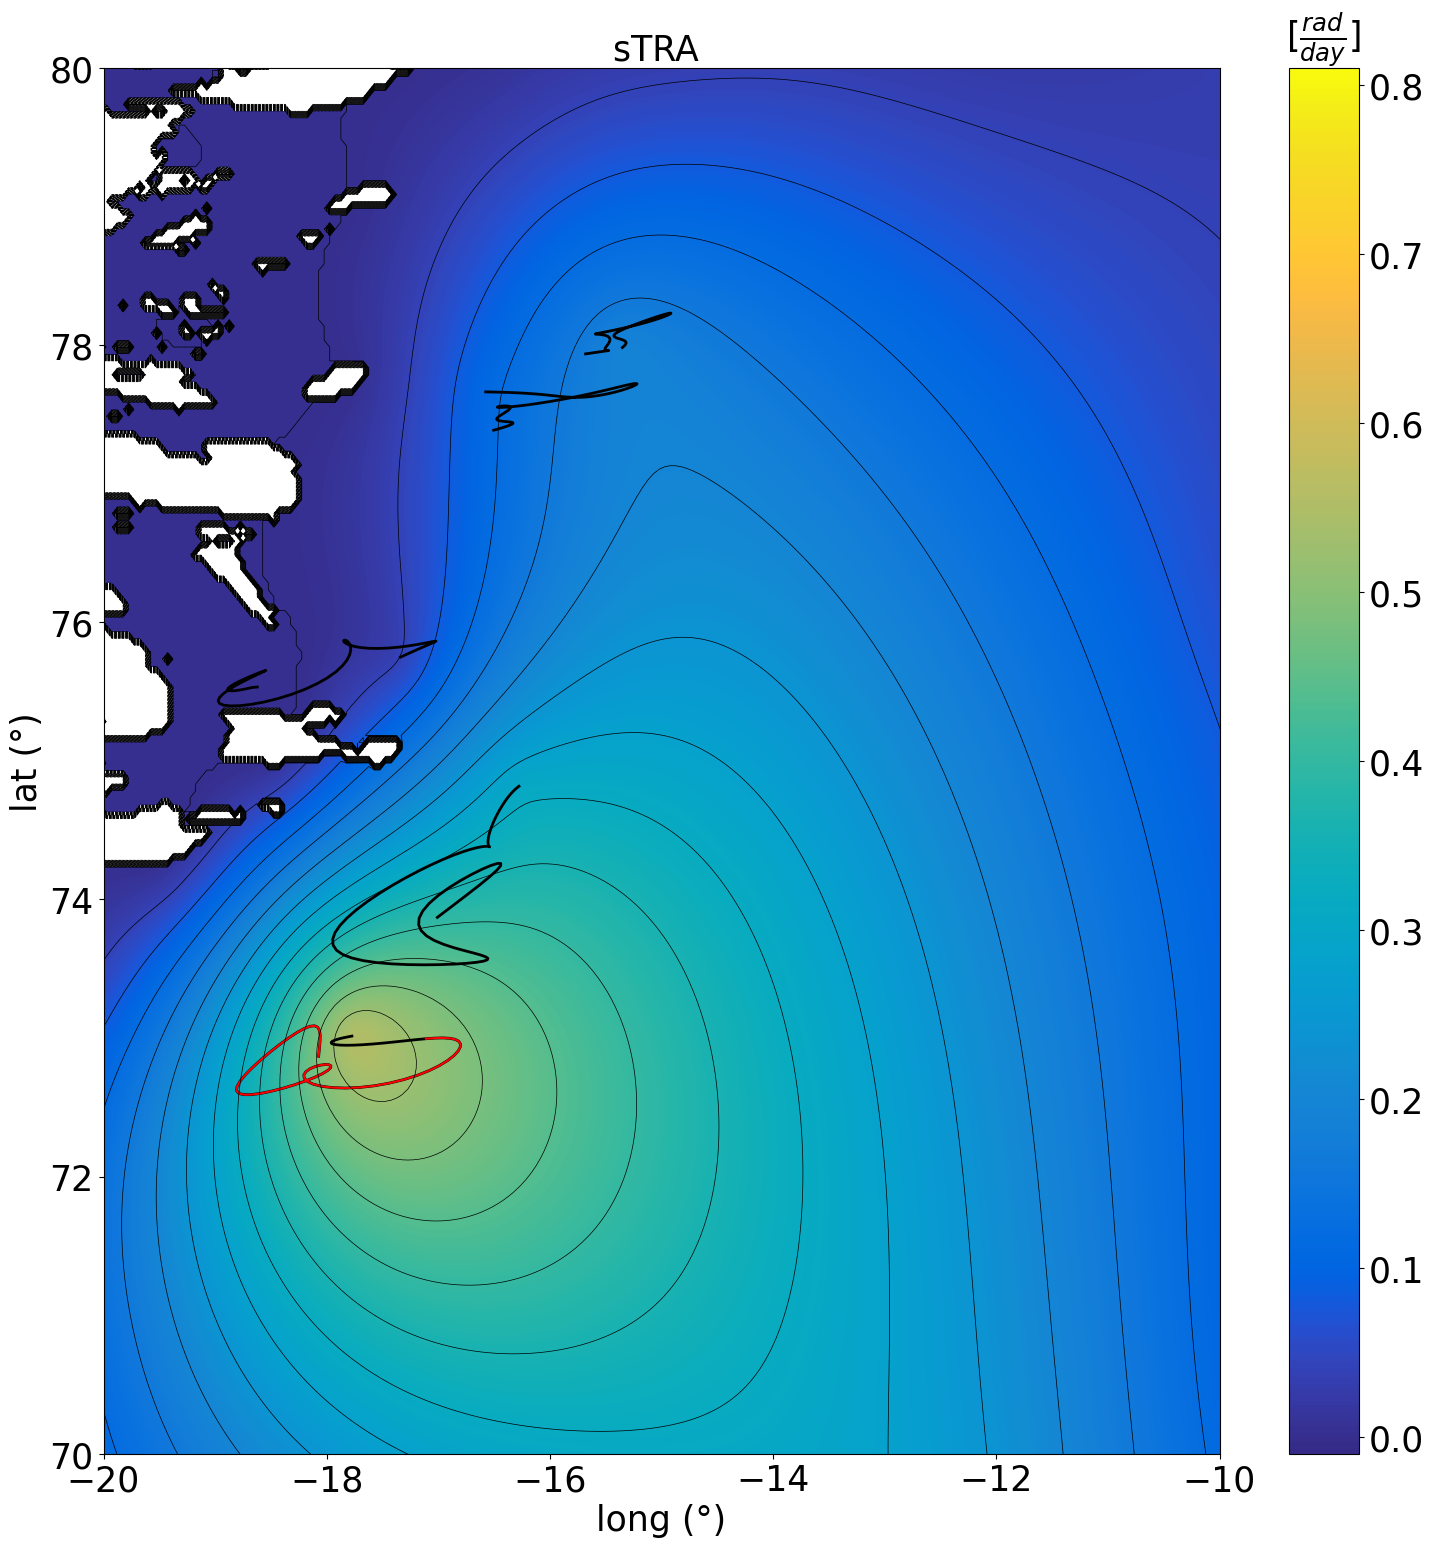

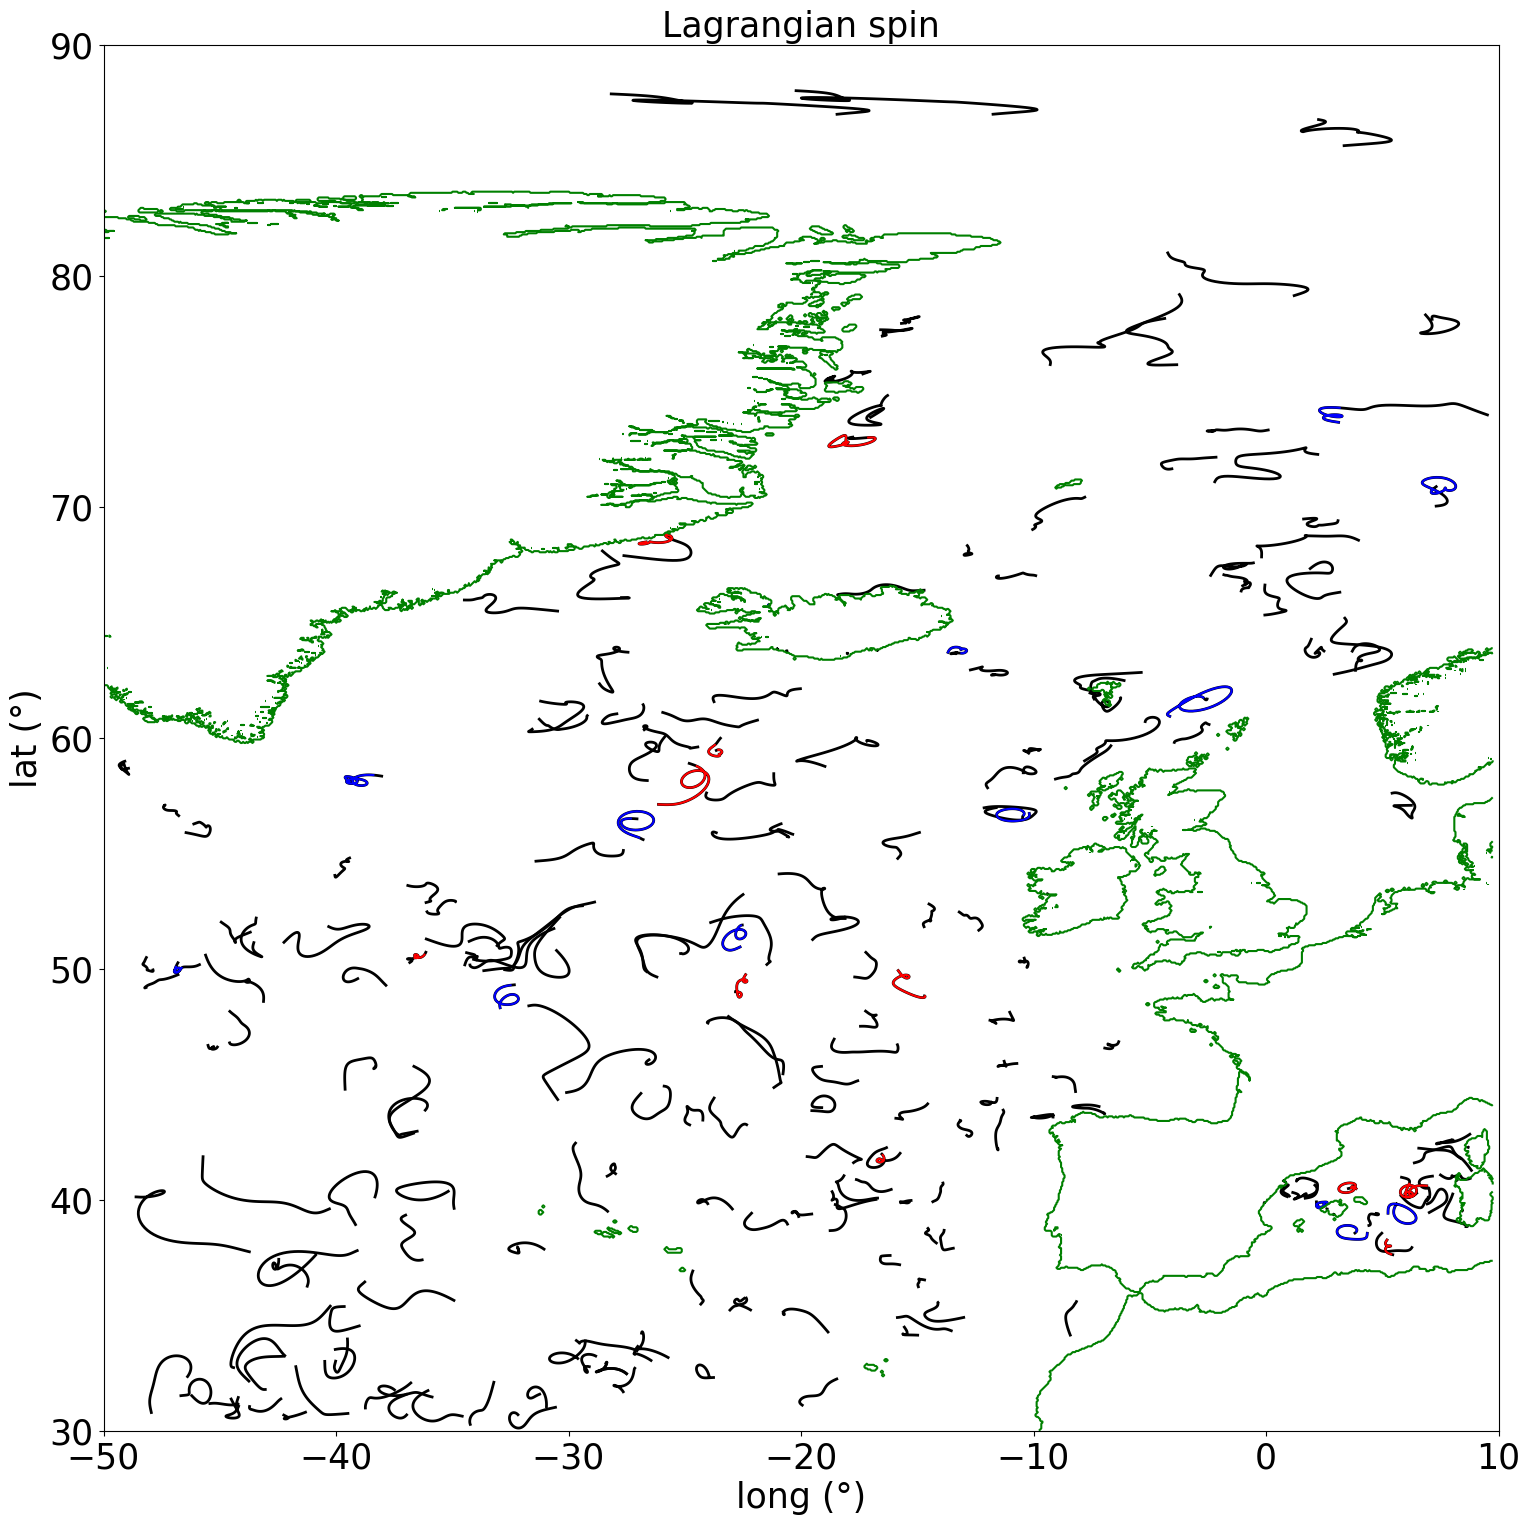

In [17]:
## main:
## - applies TRA__() to csv files of drifters
## - applies TRA_map_() to TRA of drifters
########################################################################################################
##extraction parameters:

##spatial range of region of interest in Degrees
long0 = -50
long = 10
lat0 = 30
lat = 90

##temporal range of region of interest
#time0 = '2022-09-10T00:00:00Z'
time0 = '2022-08-23T00:00:00Z' ##starttime
#time = '2022-08-30T00:00:00Z' ##end time 7days
#time = '2022-09-06T00:00:00Z' ##end time 14days
time = '2022-09-13T00:00:00Z' ##end time 21days
#time = '2022-09-20T00:00:00Z' ##end time 28days


####################################
##filtering parameters:

##factor of cutoff frequency:
#cutoff = 0.5
#cutoff = 1.0
cutoff = 1.5
#cutoff = 1.25
#cutoff = 2.0
#cutoff = 2.5
#cutoff = "inf"

##sampling period (h)
interval_ = 6

##if low pass filter applied: "filtering" = "True" 
filtering = True

###################################################################################################################
##parameters Loopers:

##if with loopers : "with_loopers" = 1
with_loopers = 1
#with_loopers = 0

##if looping segemts are to be plotted separately:
plot_loop_sep = True


###################################
##parameters TRA

##drifter threshold for vortex
N_drifters = 1

##TRA threshold for vortex
factor_thres = 0.5

##resolution of TRA interpolation
res_interpolation = 0.05

##"sign1" = "u" for normal TRA, "sign1" = "s" for signed TRA (clockwise rotation of velocity vector is negative angle)
sign1 = 's'
#sign1 = 'u'

##"abs1" = "True" for absolute value of sTRA, "abs1" = False for signed sTRA
abs1 = True
#abs1 = False

##plot vortex boundaries
with_boundaries = False

################################################################################################################
##Data Locations:
##-path
##--path_folders
##---path_data
##----path0
##-----path_filtered
##-----path_unfiltered
##----raw_download

##Path in PC
path = "C:/Mario/TBarrier/TBarrier/Untitled Folder/"

##Folder "TRA_data" in "path"
path_folders = "%sTRA_data/" % path

##Folder with spatial range in "TRA_data"
path_data = "%slong_%s_%s_lat_%s_%s_/" % ( path_folders ,long0, long, lat0, lat)

##Folder with Timeframe, filtering parameters in "path_data"

##time interval between "time0" and "time" in days
DD = np.int_(utc_to_minutes(time,time0)/60/24)

if filtering == True:
    path0 = "%stime0_%s_%s_days/filter_%s_cutoff_%s/sampling period_%s/" % (path_data,utc_(time0), DD,filtering, cutoff, interval_ )
else:
    path0 = "%stime0_%s_%s_days/filter_%s/sampling period_%s/" % (path_data,utc_(time0), DD,filtering, interval_ )


##Folder with filtered, unfiltered data
path_filtered = "%sfiltered/" % path0
path_unfiltered = "%sunfiltered/" %path0
path_files ="%stime0_%s_%s_days" % (path_data, utc_(time0), DD)

#######################################
##Download, read data
##records time program takes to run
start_time = TIME.time()


##website_path = "http://osmc.noaa.gov/erddap/tabledap/OSMC_30day.csv?platform_code%2Cplatform_type%2Ctime%2Clatitude%2Clongitude%2Csst%2Cslp%2Clon360&platform_type=%22DRIFTING%20BUOYS%20(GENERIC)%22&orderBy(%22platform_code%2Ctime%22)"
##data = pd.read_csv(website_path)

##path of downloaded file from website
file_path = "%sraw_download.csv" % path_folders
data = pd.read_csv(file_path)


#################################

## extract all drifter IDs in "data" into array "floaters" (21 data points required fr interpolation => 10 data points sampling period sufficient)
floaters = [int(data['platform_code'][1])]
"""
for i in tqdm(range(2, len(data['platform_code'])-1), desc = "finding drifter IDs"):
    if data['platform_code'][i]!= data['platform_code'][i+1]:
        floaters = np.append(floaters,int(data['platform_code'][i]))
"""
for i in tqdm(range(1, len(data['platform_code']),10), desc = "finding drifter IDs"):
    if data['platform_code'][i]!= floaters[-1]:
        floaters = np.append(floaters,int(data['platform_code'][i]))

##plot:
#fig, ax = plt.subplots(2,1,figsize=(18, 18))
fig, ax = plt.subplots(1,1,figsize=(18,18))
if sign1 == 's':
    #plt.title('%sTRA ' r'$[\frac{rad}{day}]$' %sign1, fontsize=25)
    plt.title('%sTRA ' %sign1, fontsize=25)
else:
    #plt.title('TRA ' r'$[\frac{rad}{day}]$', fontsize=25)
    plt.title('TRA ', fontsize=25)
ax.set_xlabel("long (°)", fontsize = 25)
ax.set_ylabel("lat (°)", fontsize = 25)
#ax.set_xticklabels(x_ticks, rotation=0, fontsize=8)
#ax.set_yticklabels(y_ticks, rotation=0, fontsize=8)
ax.tick_params(axis='x', labelsize=25)
ax.tick_params(axis='y', labelsize=25)

##axis limits for zoomed views of TRA field:

##zoomed_1
#ax.set_xlim(-25,-5)
#ax.set_ylim(50,70)

##zoomed_2
ax.set_xlim(-20,-10)
ax.set_ylim(70,80)

##zoomed_3
#ax.set_xlim(-30,-20)
#ax.set_ylim(55,65)

##zoomed_4
#ax.set_xlim(-45,-35)
#ax.set_ylim(55,65)

##full map
#ax.set_xlim(long0, long)
#ax.set_ylim(lat0, lat)

##separate plot for looping trajectories
if plot_loop_sep:
    figl, axl = plt.subplots(1,1,figsize=(18,18))
    plt.title('Lagrangian spin', fontsize=25)
    axl.set_xlabel("long (°)", fontsize = 25)
    axl.set_ylabel("lat (°)", fontsize = 25)
    axl.set_xlim(long0, long)
    axl.set_ylim(lat0, lat)
    axl.tick_params(axis='x', labelsize=25)
    axl.tick_params(axis='y', labelsize=25)




## end coordinates, TRA values of drifters in "Floaters"
lat_c = []
long_c = []
TRA = []
Floaters = []

##array containing loopers
Loopers = []

##check if csv file corresponding to drifter "floaters" exists, if csv file exists append drifter ID to "Floaters"
for i in tqdm(range(len(floaters)), desc = "Finding drifter files"):
    if os.path.exists("%sfiltered/%s.csv" % (path0,floaters[i])) == 1:        
        ## if csv file exists append drifter ID to "Floaters"
        Floaters = np.append(Floaters,floaters[i])
Floaters = np.int_(Floaters)

##sampling frequency (1/day)
f = np.int_(24/interval_)

## apply TRA to valid drifters (in temporal, spatial range and more than 21 data points)
for i in tqdm(range(len(Floaters)), desc = "Computing TRA, Loopers"):
    ##filtered drifters
    data2 = pd.read_csv("%sfiltered/%s.csv" % (path0,Floaters[i]))
    ##unfiltered drifters
    data3 = pd.read_csv("%sunfiltered/%s_unfiltered.csv" % (path0,Floaters[i]))
    ##append TRA value corresponding to drifter "Floaters[i]" to array "TRA"
    TRA = np.append(TRA,TRA__(data2,Floaters[i],cutoff, sign1, abs1,f))
    
    ##end coordinates of drifters
    lat_c = np.append(lat_c, data2['lat'][len(data2)-1])
    long_c = np.append(long_c, data2['long'][len(data2)-1])
    
    ##plot drifter trajectories    
    if with_loopers != 1:
        ax.plot( data2['long'][:],data2['lat'][:],label = "%s" % round(Floaters[i]), linewidth=2.0, c = "k")#, linestyle='dotted')
        
    if with_loopers == 1:
        ax.plot( data2['long'][:],data2['lat'][:],label = "%s" % round(Floaters[i]), linewidth=2.0, c = "k")#, linestyle='dashdot')        
        axl.plot( data2['long'][:],data2['lat'][:],label = "%s" % round(Floaters[i]), linewidth=2.0, c = "k")#, linestyle='dashdot')        
    
    ##plot drifter id at end of trajectory:
    #axl.text(long_c[-1],lat_c[-1],"%s" % Floaters[i] ,fontsize = 6)
    
    ##if "with_loopers" == 1, loopers are computed, plotted        
    if with_loopers == 1:        
        Loopers.append(Loopers_(data2, Floaters[i], long0, long, lat0, lat , f))

##if "with_loopers" == 1, Loopers are plotted
if with_loopers == 1:
    Loopers_map_(Loopers,long0,long,lat0,lat, plot_loop_sep) 

##TRA map is interpolated, plotted, plot is saved in 
TRA_map_(TRA,lat0, lat, lat_c,long0, long, long_c, res_interpolation, factor_thres, N_drifters, sign1, abs1, with_boundaries) 

if plot_loop_sep:
    figl.savefig("%s_LS_interval_%s_cutoff_%s.jpg" % (path_files,interval_, cutoff), bbox_inches='tight', dpi=150)
     

print("--- %s seconds ---" % (TIME.time() - start_time))

### 